In [145]:
import numpy as np
import pandas as pd
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
import random

## We are given this database coming from the historical records of a hospital

In [146]:
df = pd.read_csv("sample")
df

,smoker,treatment,dead
0,0,0,0
1,1,1,0
2,1,1,0
3,0,1,0
4,0,0,0
...,...,...,...
999995,0,0,0
999996,1,1,0
999997,0,0,0
999998,0,0,0


## And we are asked: 
## Question: How much will number of deads change if we decide treat everybody from now on with respect to not treating anyone? 

## We can use matching on propensity score
### We start computing the propensities of each sample. 
### Recall that from the paper
\begin{align}
e(x)=p(z=1|x)
\end{align}
### in our case:
\begin{align}
e(smoker)=p(treatment=1|smoker)
\end{align}


### We start by computing the propensity of each patient

In [147]:
n_smokers = len(df[df["smoker"]==1])
n_treated_smokers = len(df[(df["smoker"]==1) & (df["treatment"]==1)])
e_smoker = n_treated_smokers/n_smokers
print(e_smoker)

0.551550247155304


In [148]:
n_non_smokers = len(df[df["smoker"]==0])
n_treated_non_smokers = len(df[(df["smoker"]==0) & (df["treatment"]==1)])
e_non_smoker = n_treated_non_smokers/n_non_smokers
print(e_non_smoker)

0.20002946321174753


In [149]:
df["propensity"] = df["smoker"]*e_smoker + (1-df["smoker"])*e_non_smoker
df

,smoker,treatment,dead,propensity
0,0,0,0,0.200029
1,1,1,0,0.551550
2,1,1,0,0.551550
3,0,1,0,0.200029
4,0,0,0,0.200029
...,...,...,...,...
999995,0,0,0,0.200029
999996,1,1,0,0.551550
999997,0,0,0,0.200029
999998,0,0,0,0.200029


### We match each treated patient with a control patient that has the same propensity score. However, we reduce the number of treated patients for efficiency reasons.

In [153]:
treated = df[df["treatment"]==1].sample(100)
treated = treated.reset_index(drop=True)
treated

,smoker,treatment,dead,propensity
0,1,1,0,0.551550
1,1,1,1,0.551550
2,1,1,1,0.551550
3,0,1,0,0.200029
4,0,1,0,0.200029
...,...,...,...,...
95,0,1,0,0.200029
96,1,1,0,0.551550
97,1,1,0,0.551550
98,1,1,0,0.551550


### We match each treated patient with a randomly sampled untreated patient with the same propensity score

In [154]:
untreated = df[df["treatment"]==0]
matched_control = []
def add_matched_control(patient):
    control_patient = untreated[untreated["propensity"]==patient["propensity"]].sample().iloc[0]
    matched_control.append(control_patient)
    
treated.apply(add_matched_control, axis=1)
matched_control_df = pd.DataFrame(matched_control).reset_index(drop=True)
matched_control_df

,smoker,treatment,dead,propensity
0,1.0,0.0,1.0,0.551550
1,1.0,0.0,0.0,0.551550
2,1.0,0.0,1.0,0.551550
3,0.0,0.0,0.0,0.200029
4,0.0,0.0,0.0,0.200029
...,...,...,...,...
95,0.0,0.0,0.0,0.200029
96,1.0,0.0,1.0,0.551550
97,1.0,0.0,1.0,0.551550
98,1.0,0.0,0.0,0.551550


In [155]:
paired_sample = treated.join(matched_control_df, rsuffix="_control")
paired_sample


,smoker,treatment,dead,propensity,smoker_control,treatment_control,dead_control,propensity_control
0,1,1,0,0.551550,1.0,0.0,1.0,0.551550
1,1,1,1,0.551550,1.0,0.0,0.0,0.551550
2,1,1,1,0.551550,1.0,0.0,1.0,0.551550
3,0,1,0,0.200029,0.0,0.0,0.0,0.200029
4,0,1,0,0.200029,0.0,0.0,0.0,0.200029
...,...,...,...,...,...,...,...,...
95,0,1,0,0.200029,0.0,0.0,0.0,0.200029
96,1,1,0,0.551550,1.0,0.0,1.0,0.551550
97,1,1,0,0.551550,1.0,0.0,1.0,0.551550
98,1,1,0,0.551550,1.0,0.0,0.0,0.551550


In [157]:

ATE = (paired_sample["dead"]-paired_sample["dead_control"]).mean()
ATE

-0.17

## Response: The percentage of deads is estimated to decrease!!!
## Consequently, we should treat our population.

### However, we know that the real ATE is 0.083. Why is this calculation so inacurate? ...

### Let's take an alternative path to use propensity score matching
### We start by taking a look at the distribution of propensity scores

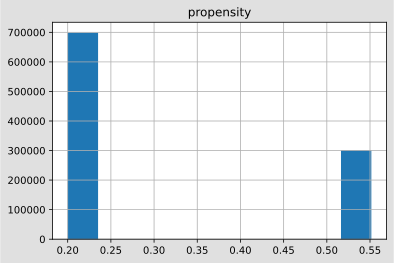

In [158]:
df.hist("propensity");

### We can split patients into two groups, those with high propensity (> 0.5) and those with low propensity (<=0.5)

In [159]:
high_propensity = df[df["propensity"]>0.5]
low_propensity = df[df["propensity"]<=0.5]
counts = np.array([len(low_propensity), len(high_propensity)])
percentages= counts / np.sum(counts)
percentages

array([0.699177, 0.300823])

### Build a paired sample 

In [163]:
n_samples=1000
samples = []
for i in range(n_samples):
    is_high_propensity = random.random()>percentages[0]
    if is_high_propensity:
        treated_patient = high_propensity[high_propensity["treatment"]==1].sample().iloc[0]
        untreated_patient = high_propensity[high_propensity["treatment"]==0].sample().iloc[0]
    else:
        treated_patient = low_propensity[low_propensity["treatment"]==1].sample().iloc[0]
        untreated_patient = low_propensity[low_propensity["treatment"]==0].sample().iloc[0]
    samples.append((treated_patient, untreated_patient))

In [164]:
individual_treatment_effect = np.zeros(n_samples)
i = 0
for t, c in samples:
    individual_treatment_effect[i] = t["dead"]-c["dead"]
    i+=1


In [165]:
ATE=individual_treatment_effect.mean()
ATE

-0.074

### We have managed to reduce the bias by sampling first from the distribution of propensity scores. 
### Can we do better?